<a href="https://colab.research.google.com/github/kalisetty23/NLP/blob/main/M3_Part_I_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)##Assignment 3 Naïve Bayes and Sentiment Classification and Logistic Regression
Instructions
* Read the following Chapter 4: Naive Bayes and Sentiment Classification. Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2021. All rights reserved. Draft of September 21, 2021. I have tried to pull out relevant notes for you below, but it is encouraged that you read each chapter provided.
* Read the following Chapter 5: Logistic Regression. Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2021. All rights reserved. Draft of September 21, 2021. I have tried to pull out relevant notes for you below, but it is encouraged that you read each chapter provided.

Summary
Classification is one of the most important tasks of NLP and in machine learning. In NLP it often means the task of text categorization for both sentiment analysis, spam detection, and topic modeling. Naïve Bayes is often one of the first classification algorithms defined in NLP.  The intuition behind a classifier is lies at the underlying probability inferred by the Bayesian Inference, which uses Baye’s rule and conditional probabilities.

Here’s a reminder on Baye’s Rule:
P(y)=P(x)P(x)/(P(y))

We are saying “what is the probability of x given y”. Naïve Bayes is a generative model because there is an input that helps the model determine what the output could be. Said differently, “to train a generative model we first collect a large amount of data in some domain (e.g., think millions of images, sentences, or sounds, etc.) and then train a model to generate data like it.” [6]

So in the case of Naïve Bayes, we say given some word, what should be the class of the current word we are assessing? Contrastingly, discriminative models such as logistic regression, learn from features provided to the algorithm and then determine or predict what the class is. [7]


With Naïve Bayes, the assumption is that the probabilities are independent. We often call the Naïve Bayes classifier the bag-of-words approach. That’s because we are essentially throwing in the collection of words into a ‘bag’, selecting a word at random, and then calculating their frequency to use in the Bayesian Inference. Thus, context – the position of words -- is ignored and despite this, it turns out that the Naïve Bayes approach can be accurate and effective at determining whether an email is spam for example.

Back to bag of words. With bag of words, we assume that the position of the words are not relevant -- that dependency or context in the word phrase or sentence doesn’t matter. Relatedly, the naive Bayes assumption implies that the conditional probabilities are independent -- a rather strange assumption to make for words in a sentence! The equation for the naive Bayes classifier is outlined below:

You can use Naive Bayes by creating an index of words and walking through every word position in a test or corpus.


It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.

For this Assignment, you can start with a spam/ham dataset, then predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).   One example corpus:   https://spamassassin.apache.org/old/publiccorpus/

You may work alone or in a group on this project.  You're welcome to use any tools or approach that you like.  Due before our next meetup. Starter code provided below.

Test example is provided at the end.

Libraries you may wish to use

In [26]:
import pandas as pd
import numpy as np
from os import makedirs, path, remove, rename, rmdir
from tarfile import open as open_tar
from shutil import rmtree
from urllib import request, parse
from glob import glob
from os import path
from re import sub
from email import message_from_file
from glob import glob
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import gc


download corpus using the following functions

Note: you may need to mount your drive on google then run this location. See previous exercises.

In [2]:
def download_corpus(dataset_dir: str = 'data'):
    base_url = 'https://spamassassin.apache.org'
    corpus_path = 'old/publiccorpus'
    files = {
        '20021010_easy_ham.tar.bz2': 'ham',
        '20021010_hard_ham.tar.bz2': 'ham',
        '20021010_spam.tar.bz2': 'spam',
        '20030228_easy_ham.tar.bz2': 'ham',
        '20030228_easy_ham_2.tar.bz2': 'ham',
        '20030228_hard_ham.tar.bz2': 'ham',
        '20030228_spam.tar.bz2': 'spam',
        '20030228_spam_2.tar.bz2': 'spam',
        '20050311_spam_2.tar.bz2': 'spam' }

    #creates the folders: downloads, ham and spam
    downloads_dir = path.join(dataset_dir, 'downloads')
    ham_dir = path.join(dataset_dir, 'ham')
    spam_dir = path.join(dataset_dir, 'spam')

    makedirs(downloads_dir, exist_ok=True)
    makedirs(ham_dir, exist_ok=True)
    makedirs(spam_dir, exist_ok=True)


    for file, spam_or_ham in files.items():
        # download files from URL of each specific .bz2 file
        url = parse.urljoin(base_url, f'{corpus_path}/{file}')
        tar_filename = path.join(downloads_dir, file)
        request.urlretrieve(url, tar_filename)

        #list e-mails in the compressed .bz2 file
        emails = []
        with open_tar(tar_filename) as tar:
            tar.extractall(path=downloads_dir)
            for tarinfo in tar:
                if len(tarinfo.name.split('/')) > 1:
                    emails.append(tarinfo.name)

        # move e-mails to ham or spam directory
        for email in emails:
            directory, filename = email.split('/')
            directory = path.join(downloads_dir, directory)

            if not path.exists(path.join(dataset_dir, spam_or_ham, filename)):
                rename(path.join(directory, filename),
                   path.join(dataset_dir, spam_or_ham, filename))

        rmtree(directory)

download_corpus()

In [3]:
download_corpus()

#How many e-mails are classified in our dataset as either Spam or not Spam?


In [4]:
#How many e-mails are classified in our dataset as either Spam or not Spam?
ham_dir = path.join('data', 'ham')
spam_dir = path.join('data', 'spam')

print('Number of Non-Spam E-mails:', len(glob(f'{ham_dir}/*')))
print('\nNumber of Spam E-mails:', len(glob(f'{spam_dir}/*')))

Number of Non-Spam E-mails: 6952

Number of Spam E-mails: 2399


Provide your classifier below

In [5]:
# Preprocessing functions
def clean_text(text):
    text = sub(r'\W+', ' ', text.lower())  # Remove non-word characters and convert to lowercase
    text = sub(r'\s+', ' ', text)  # Remove extra whitespaces
    return text.strip()

def extract_text_from_email(email_path):
    with open(email_path, 'r', errors='ignore') as f:
        email_message = message_from_file(f)
        if email_message.is_multipart():
            for part in email_message.walk():
                content_type = part.get_content_type()
                if content_type == 'text/plain':
                    text = part.get_payload(decode=True).decode(errors='ignore')
                    return clean_text(text)
        else:
            return clean_text(email_message.get_payload(decode=True).decode(errors='ignore'))



In [22]:
# Load the dataset
ham_files = len(glob(f'{ham_dir}/*'))
spam_files = len(glob(f'{spam_dir}/*'))
emails = [(extract_text_from_email(file), 'ham') for file in glob(f'{ham_dir}/*')] + [(extract_text_from_email(file), 'spam') for file in glob(f'{spam_dir}/*')]

df = pd.DataFrame(emails, columns=['text', 'label'])

df

,text,label
0,original message from james rogers jamesr best...,ham
1,url http diveintomark org archives 2002 09 23 ...,ham
2,on thu sep 05 2002 at 10 12 59pm 0400 leland w...,ham
3,adam l beberg wrote so who has done rsa implem...,ham
4,an apparent quote from dubya from the times se...,ham
...,...,...
9346,html head meta http equiv content type content...,spam
9347,ford salutes the military this offer is extend...,spam
9348,html head title title meta http equiv content ...,spam
9349,important information the new domain names are...,spam


In [8]:
# Split the dataset into training and testing sets
# Split the dataset into train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
test_set = pd.DataFrame(columns=['text', 'label'])
for train_index, test_index in split.split(df, df['label']):
    test_set['text'].fillna('', inplace=True)
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [17]:
test_set

,text,label
6278,g gregory alan bolcer gbolcer endeavors com wr...,ham
7992,html head title title head body bgcolor ffffff...,spam
9161,dear reader how has veuve clicquot s sponsorsh...,spam
2255,on tue aug 13 2002 at 12 48 18am 0100 wintermu...,ham
5226,i wonder if the ceo dig also suggests propriet...,ham
...,...,...
523,from brent welch welch panasas com date wed 28...,ham
4835,on 0020 0100 mon aug 19 2002 at 11 30 12pm 010...,ham
8413,html div nbsp div font size 2 ptsize 10 table ...,spam
2999,url http www newsisfree com click 1 8408636 17...,ham


In [18]:
train_index

array([8637, 7210, 1194, ..., 3050, 2772, 1556])

In [19]:
train_set

,text,label
8637,i saw your email on a website i visited yester...,spam
7210,we are offering you quality marketing lists wh...,spam
1194,on fri 2 aug 2002 kevin lyda wrote on fri aug ...,ham
7809,financial power you can depend on very competi...,spam
6706,on mon 2 sep 2002 russell turpin wrote adam be...,ham
...,...,...
8851,hr html div bgcolor ffffcc p align center a hr...,spam
5520,i m listed as a developer on sf and have the s...,ham
3050,html head title internet services weekly newsl...,ham
2772,if you re using a break or similar construct i...,ham


In [9]:
# Train the Naive Bayes classifier
class NaiveBayesClassifier:
    def __init__(self):
        self.word_counts = defaultdict(partial(defaultdict, int))
        self.class_counts = defaultdict(int)

    def train(self, X_train, y_train):
        for text, label in zip(X_train, y_train):
            for word in text.split():
                self.word_counts[label][word] += 1
                self.class_counts[label] += 1


    def predict(self, X_test):
       predictions = []
       for text in X_test:
           if text is None:
               predictions.append('ham')  # Return a default prediction for None values
               continue
           ham_prob = np.log(self.class_counts['ham'] / sum(self.class_counts.values()))
           spam_prob = np.log(self.class_counts['spam'] / sum(self.class_counts.values()))
           for word in text.split():
               ham_prob += np.log((self.word_counts['ham'][word] + 1) / (self.class_counts['ham'] + len(self.word_counts['ham'])))
               spam_prob += np.log((self.word_counts['spam'][word] + 1) / (self.class_counts['spam'] + len(self.word_counts['spam'])))
           prediction = 'spam' if spam_prob > ham_prob else 'ham'
           predictions.append(prediction)
       return predictions

In [27]:
# Train and evaluate the classifier
classifier = NaiveBayesClassifier()
train_set['text'].fillna('', inplace=True)
classifier.train(train_set['text'], train_set['label'])
predictions = classifier.predict(test_set['text'])

# Evaluate the performance
print('Accuracy:', accuracy_score(test_set['label'], predictions))
print('Precision:', precision_score(test_set['label'], predictions, average='weighted'))
print('Recall:', recall_score(test_set['label'], predictions, average='weighted'))
print('F1-Score:', f1_score(test_set['label'], predictions, average='weighted'))




Accuracy: 0.9791555318011759
Precision: 0.9792519275076415
Recall: 0.9791555318011759
F1-Score: 0.9789696860428243


Confusion Matrix:
[[1384    7]
 [  32  448]]


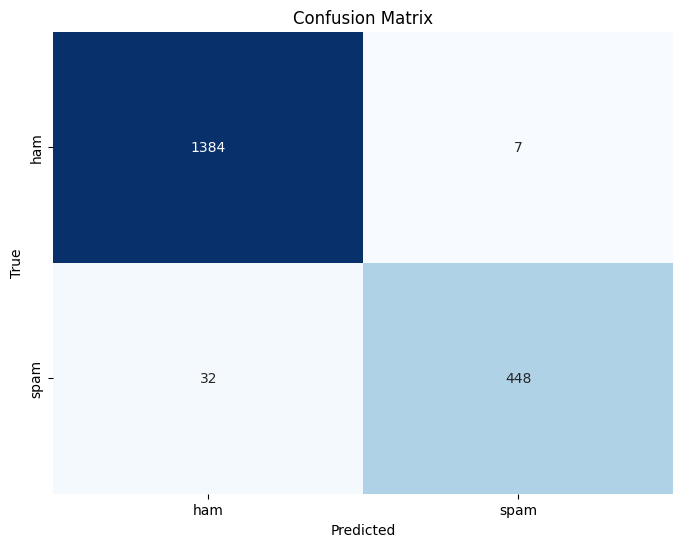

In [29]:
# Calculating  the confusion matrix
cm = confusion_matrix(test_set['label'], predictions)
print("Confusion Matrix:")
print(cm)
# Creating a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The following email is a test email. You can take this and test your classifier to see if it predicts spam or not.



In [11]:
spam_email = """
Subject: Get Rich Quick!

Dear Friend,

Congratulations! You've been selected to participate in an exclusive opportunity to make thousands of dollars from the comfort of your own home. Our revolutionary system guarantees quick and easy cash with minimal effort.

No more struggling to pay bills or worrying about financial security. With our proven method, you can start earning massive amounts of money in no time.

Here's what some of our satisfied customers have to say:
- "I was skeptical at first, but I'm now living my dream life thanks to this incredible system!" - John S.
- "I never thought making money online could be this simple. It's changed my life!" - Sarah L.

Don't miss out on this limited-time offer. Act now to secure your spot and start enjoying a life of financial freedom.

Click the link below to get started:
www.getrichquick.com

Remember, this opportunity is exclusive and won't last long. Take control of your financial future today!

Best regards,
The Get Rich Quick Team
"""
test_email = clean_text(spam_email)
prediction = classifier.predict([test_email])[0]
print('Predicted Label:', prediction)

Predicted Label: spam


In [12]:
spam_email = """
Hi there,

X

Thank you for being part of the Lightbend community. We wanted to let you know that we have made some updates to Lightbend's Privacy Policy and Cookie Policy in preparation for the EU's Data Protection Regulation that will be effective on May 25, 2018

Changes include

• Greater transparency into what type of data is being collected, processed and disclosed

Detailed instructions on how to access, correct or delete your personal information The new Cookie Policy explains what type of cookies are being used as part of our

services and allows users to more easily restrict sharing of personal data

At Lightbend, we are strongly committed to protecting the privacy of personal data that we maintain about Lightbend clients, employees and other individuals interested in the Reactive and Fast Data journey
"""
test_email = clean_text(spam_email)
prediction = classifier.predict([test_email])[0]
print('Predicted Label:', prediction)

Predicted Label: ham


In [13]:
spam_email = """
Chase: Important notification regarding your chase bank debit/credit/ATM/Prepaid Card.

Dear Customer

As part of our security commitment to safeguard your online banking transactions and activities, this notification is to confirm that you or an authorized party used your account information's for online transactions using your chase debit/credit card details.

To view and confirm this transaction, kindly click the button below

View all Transactions

Chase Card Services Email Operations Team

Your privacy is important to us. See our online Security Center to learn how to protect your information. Chase Privacy Operations, P.O. Box 659752, San Antonio, TX 78265-9752.

©2019 JP Morgan Chase Bank, N.A. Member FDIC

"""
test_email = clean_text(spam_email)
prediction = classifier.predict([test_email])[0]
print('Predicted Label:', prediction)

Predicted Label: spam
